# Hate Speech Overview

In [3]:
import pandas as pd
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
comments = pd.read_csv('attack_annotated_comments.tsv', sep = '\t', index_col = 0)
annotations = pd.read_csv('attack_annotations.tsv',  sep = '\t')
labels = annotations.groupby('rev_id')['attack'].mean() > 0.5
# join labels and comments
comments['attack'] = labels
# remove newline and tab tokens
comments['comment'] = comments['comment'].apply(lambda x: x.replace("NEWLINE_TOKEN", " "))
comments['comment'] = comments['comment'].apply(lambda x: x.replace("TAB_TOKEN", " "))

#Example Comments with Toxic intent
comments.query('attack')['comment'].head(n=10)

rev_id
801279             Iraq is not good  ===  ===  USA is bad   
2702703      ____ fuck off you little asshole. If you wan...
4632658         i have a dick, its bigger than yours! hahaha
6545332      == renault ==  you sad little bpy for drivin...
6545351      == renault ==  you sad little bo for driving...
7977970    34, 30 Nov 2004 (UTC)  ::Because you like to a...
8359431    `  ::You are not worth the effort. You are arg...
8724028    Yes, complain to your rabbi and then go shoot ...
8845700                     i am using the sandbox, ass wipe
8845736      == GOD DAMN ==  GOD DAMN it fuckers, i am us...
Name: comment, dtype: object

In [4]:
#percentage of the insult and none insult comments
print("None insult percentage:",len(comments[comments['attack']==False])/len(comments)*100)
print("Insult percentage:", len(comments[comments['attack']==True])/len(comments)*100)

None insult percentage: 88.27073120209901
Insult percentage: 11.729268797900987


In [6]:
#Do some magic with ngrams
import matplotlib.pyplot as plt
import networkx as nx
import nltk
from nltk.util import ngrams
%matplotlib inline

def generate_ngrams(text, n=2):
    words = text.split()
    iterations = len(words) - n + 1
    for i in range(iterations):
       yield words[i:i + n]
       
       
# None insult comment
ngrams = {}
for title in comments[comments.attack==False]['comment']:
        for ngram in generate_ngrams(title, 2):
            ngram = ' '.join(ngram)
            if ngram in ngrams:
                ngrams[ngram] += 1
            else:
                ngrams[ngram] = 1

ngrams_acd_df = pd.DataFrame.from_dict(ngrams, orient='index')
ngrams_acd_df.columns = ['count']
ngrams_acd_df['abuse'] = 'False'
ngrams_acd_df.reset_index(level=0, inplace=True)

# Insult comment
ngrams = {}
for title in comments[comments.attack==True]['comment']:
        for ngram in generate_ngrams(title, 2):
            ngram = ' '.join(ngram)
            if ngram in ngrams:
                ngrams[ngram] += 1
            else:
                ngrams[ngram] = 1

ngrams_wc_df = pd.DataFrame.from_dict(ngrams, orient='index')
ngrams_wc_df.columns = ['count']
ngrams_wc_df['abuse'] = 'True'
ngrams_wc_df.reset_index(level=0, inplace=True)

print(ngrams_acd_df.sort_values(by='count', ascending=False).head(10))

print(ngrams_wc_df.sort_values(by='count', ascending=False).head(10))


       index  count  abuse
10    of the  34679  False
636   in the  24805  False
341   to the  17562  False
961   on the  14366  False
528    to be  14261  False
177     is a  11871  False
706    it is  10314  False
1232  I have  10209  False
2     is not   9720  False
1160    I am   9160  False
                index  count abuse
173              is a   3102  True
7028    NIGGER NIGGER   2596  True
138757        JEW FAT   2474  True
138756        FAT JEW   2458  True
55               I am   2045  True
147257      SHIT SHIT   1999  True
9311         YOU SUCK   1703  True
658          FUCK YOU   1701  True
178151    PENIS PENIS   1667  True
47837   WANKER WANKER   1656  True


<Figure size 1440x1440 with 0 Axes>

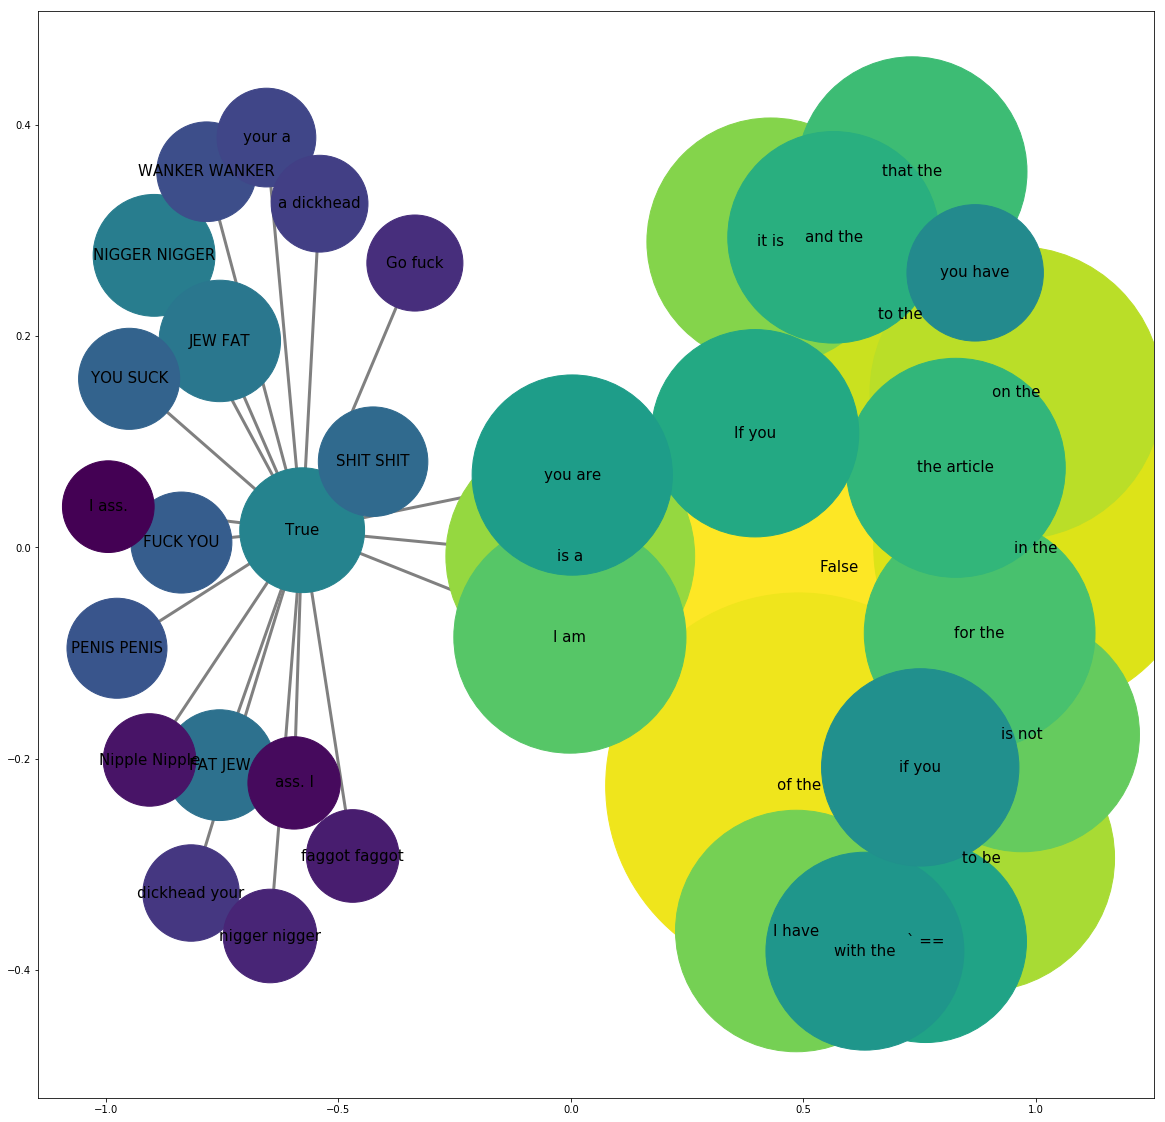

(0.0, 1.0, 0.0, 1.0)

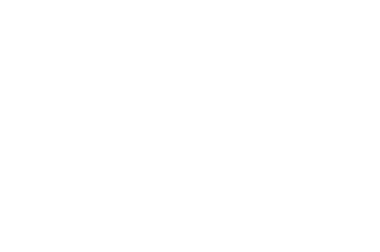

In [8]:
#Plot it onto a network diagram to show most used bigrams
bigram_df = pd.concat([ngrams_acd_df.sort_values(by='count', ascending=False).head(20),
                        ngrams_wc_df.sort_values(by='count', ascending=False).head(20)])
    
g = nx.nx.from_pandas_edgelist(bigram_df,source='abuse',target='index')
plt.figure(figsize=(20, 20))
cmap = plt.cm.viridis_r
colors = [n for n in range(len(g.nodes()))]
plt.figure(figsize=(20, 20))
k = 0.35
pos=nx.spring_layout(g, k=k)
nx.draw_networkx(g,pos, node_size=bigram_df['count'].values*6, cmap = cmap, 
                 node_color=colors, edge_color='grey', font_size=15, width=3)
plt.show()
plt.axis("off")


# Predict Abuse Comments

In [9]:
# Now fit a simple text classifier

train_comments = comments.query("split=='train'")
test_comments = comments.query("split=='test'")

clf = Pipeline([
    ('vect', CountVectorizer(max_features = 10000, ngram_range = (1,2))),
    ('tfidf', TfidfTransformer(norm = 'l2')),
    ('clf', LogisticRegression()),
])
clf = clf.fit(train_comments['comment'], train_comments['attack'])
auc = roc_auc_score(test_comments['attack'], clf.predict_proba(test_comments['comment'])[:, 1])
print('Test ROC AUC: %.3f' %auc)


Test ROC AUC: 0.957


In [10]:
# correctly classify nice comment
print('Thanks for you contribution, you did a great job!')
print(clf.predict(['Thanks for you contribution, you did a great job!']))

# correctly classify nasty comment
print('People as stupid as you should not edit Wikipedia!')
print(clf.predict(['People as stupid as you should not edit Wikipedia!']))

Thanks for you contribution, you did a great job!
[False]
People as stupid as you should not edit Wikipedia!
[ True]


In [11]:
#Use the same Model on twitter to constantly predict
import requests
from bs4 import BeautifulSoup

url = "http://twitter.com/Tweet_Maker_User_Name/status/" + "653897939933364224"
response = requests.get(url)
html = BeautifulSoup(response.text, 'html.parser')
#Magical trick for tweets
tweet_text = html.find(attrs={'class': 'js-tweet-text-container'}).text.replace("NEWLINE_TOKEN", " ")

print("A tweet from the President",tweet_text)

A tweet from the President 
The arrogant young woman who questioned me in such a nasty fashion at No Labels yesterday was a Jeb staffer! HOW CAN HE BEAT RUSSIA & CHINA?



In [13]:
#Note work more on the model as it mainly relies on the given data that a lot of faul language
print(clf.predict([tweet_text]))
print(clf.predict_proba([tweet_text]))


[False]
[[0.83655431 0.16344569]]


# HateFull Tweets 

In [16]:
#Have a looksy on how this dataset look like
all_tweets = pd.read_csv("NAACL_SRW_2016.csv",names=["id","abuse"])
all_tweets.head(n=5)

,id,abuse
0,572342978255048705,racism
1,572341498827522049,racism
2,572340476503724032,racism
3,572334712804384768,racism
4,572332655397629952,racism


['none' 'racism' 'sexism']


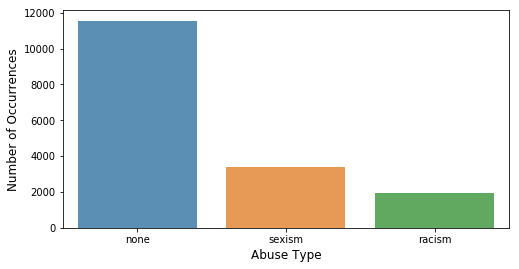

In [20]:
import numpy as np 

print(np.unique(all_tweets.abuse.values))

import seaborn as sns
cnt_srs = all_tweets['abuse'].value_counts()


plt.figure(figsize=(8,4))
sns.barplot(cnt_srs.index, cnt_srs.values, alpha=0.8)
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('Abuse Type', fontsize=12)
plt.show()

In [22]:
#The way to extract the tweets
c = 0
for i in range(len(all_tweets)):
    url = "http://twitter.com/Tweet_Maker_User_Name/status/" + str(all_tweets["id"].iloc[i])
    response = requests.get(url)
    html = BeautifulSoup(response.text, 'html.parser')
    #Magical trick for tweets
    print(all_tweets["abuse"].iloc[i], html.find(attrs={'class': 'js-tweet-text-container'}).text)
    c += 1
    if c >= 5:
        break;

racism 
So Drasko just said he was impressed the girls cooked half a chicken.. They cooked a whole one  #MKR

racism 
Drasko they didn't cook half a bird you idiot #mkr

racism 
Hopefully someone cooks Drasko in the next ep of #MKR

racism 
of course you were born in serbia...you're as fucked as A Serbian Film #MKR

racism 
These girls are the equivalent of the irritating Asian girls a couple years ago. Well done, 7. #MKR



# Toxic Comment Classification Challenge of Kaggle


In [23]:
train = pd.read_csv('train.csv')
train.head(n=10)

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0
5,00025465d4725e87,"""\n\nCongratulations from me as well, use the ...",0,0,0,0,0,0
6,0002bcb3da6cb337,COCKSUCKER BEFORE YOU PISS AROUND ON MY WORK,1,1,1,0,1,0
7,00031b1e95af7921,Your vandalism to the Matt Shirvington article...,0,0,0,0,0,0
8,00037261f536c51d,Sorry if the word 'nonsense' was offensive to ...,0,0,0,0,0,0
9,00040093b2687caa,alignment on this subject and which are contra...,0,0,0,0,0,0


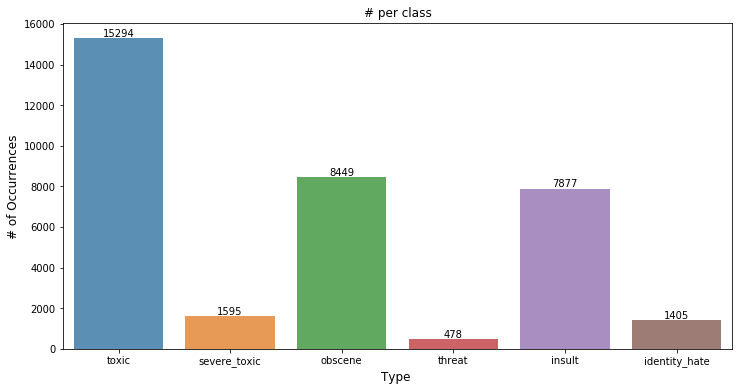

In [25]:
train = pd.read_csv('train.csv')
x=train.iloc[:,2:].sum()
#plot
plt.figure(figsize=(12,6))
ax= sns.barplot(x.index, x.values, alpha=0.8)
plt.title("# per class")
plt.ylabel('# of Occurrences', fontsize=12)
plt.xlabel('Type ', fontsize=12)
#adding the text labels
rects = ax.patches
labels = x.values
for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2, height + 5, label, ha='center', va='bottom')

plt.show()

In [27]:
#Size of the training and testing data
print("Train size", train.shape)
test = pd.read_csv('test.csv')
print("Test size", test.shape)

Train size (159571, 8)
Test size (153164, 2)


# Final Dataset

Automated Hate Speech Detection and the Problem of Offensive Language

In [29]:
train = pd.read_csv("labeled_data.csv")
train.head(n=10)
#In the class part
#0 - hate speech
#1 - offensive  language
#2 - neither

,Unnamed: 0,count,hate_speech,offensive_language,neither,class,tweet
0,0,3,0,0,3,2,!!! RT @mayasolovely: As a woman you shouldn't...
1,1,3,0,3,0,1,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...
2,2,3,0,3,0,1,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...
3,3,3,0,2,1,1,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...
4,4,6,0,6,0,1,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...
5,5,3,1,2,0,1,"!!!!!!!!!!!!!!!!!!""@T_Madison_x: The shit just..."
6,6,3,0,3,0,1,"!!!!!!""@__BrighterDays: I can not just sit up ..."
7,7,3,0,3,0,1,!!!!&#8220;@selfiequeenbri: cause I'm tired of...
8,8,3,0,3,0,1,""" &amp; you might not get ya bitch back &amp; ..."
9,9,3,1,2,0,1,""" @rhythmixx_ :hobbies include: fighting Maria..."


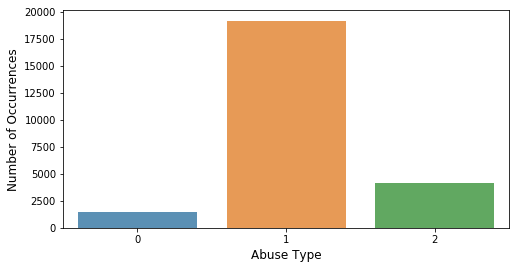

In [30]:
cnt_srs = train['class'].value_counts()


plt.figure(figsize=(8,4))
sns.barplot(cnt_srs.index, cnt_srs.values, alpha=0.8)
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('Abuse Type', fontsize=12)
plt.show()